In [1]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

## Load datasets

In [6]:
from SLTDataset import SLTDataset


# DATASETS = ["LSAT", "RWTH_PHOENIX_2014T", "GSL"]
DATASETS = ["LSAT"]
DATA_DIR = "/mnt/disk3Tb/slt-datasets/"
INPUT_MODE = "pose"
OUTPUT_MODE = "text"


datasets: dict[str, SLTDataset] = {}
for dataset in DATASETS:
    datasets[dataset] = SLTDataset(
        data_dir=DATA_DIR + dataset,
        input_mode=INPUT_MODE,
        output_mode=OUTPUT_MODE,
    )

Loaded metadata for dataset: LSA-T
Loaded  annotations at /mnt/disk3Tb/slt-datasets/LSAT/annotations.csv


Validating files: 100%|██████████| 8459/8459 [00:00<00:00, 191354.53it/s]

Missing 9 files out of 8459 (0.11%)



In [7]:
import pandas as pd

from WordLevelTokenizer import WordLevelTokenizer


def get_tokenizer(dataset: SLTDataset) -> WordLevelTokenizer:
    tokenizer = WordLevelTokenizer()
    tokenizer.fit(dataset.annotations["text"].tolist())
    return tokenizer


samples: list[tuple[str, str, float, list[int]]] = []
tokenizers = {name: get_tokenizer(dataset) for name, dataset in datasets.items()}

for name, dataset in datasets.items():
    print(f"Processing dataset {name}")
    for i in range(len(dataset)):
        pose, text = dataset.get_item_raw(i)
        token_ids = tokenizers[name].encode(text)
        samples.append((name, text, len(pose), token_ids))
df = pd.DataFrame(samples, columns=["dataset", "text", "pose_length", "token_ids"])
df["token_length"] = df["token_ids"].apply(len)

Processing dataset LSAT


In [8]:
df.head()

,dataset,text,pose_length,token_ids,token_length
0,LSAT,"para dejar en el camino tanto inglés, para que...",340,"[2, 4, 5, 6, 7, 8, 9, 10, 4, 11, 7, 12, 13, 14...",22
1,LSAT,mientras trabajábamos para brindarte toda la ...,676,"[2, 22, 23, 4, 24, 25, 26, 27, 6, 28, 29, 30, ...",45
2,LSAT,será recordado por siempre. este programa es u...,208,"[2, 51, 52, 18, 53, 54, 55, 56, 14, 57, 43, 58...",14
3,LSAT,buenas noches. bienvenidos a cn sordos argent...,196,"[2, 60, 61, 62, 43, 63, 64, 65, 7, 29, 66, 34,...",18
4,LSAT,mi nombre es lucía.,78,"[2, 70, 71, 56, 72, 3]",6


In [9]:
df.groupby("dataset").describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

dataset                    LSAT
pose_length  count  8450.000000
             mean    287.716095
             std     218.443853
             min      30.000000
             10%      90.000000
             25%     137.000000
             50%     222.000000
             75%     372.000000
             90%     569.100000
             95%     725.550000
             99%    1050.510000
             max    2695.000000
token_length count  8450.000000
             mean     18.050178
             std      11.164755
             min       3.000000
             10%       7.000000
             25%      10.000000
             50%      15.000000
             75%      23.000000
             90%      33.000000
             95%      40.000000
             99%      54.000000
             max     155.000000

In [23]:
print(f"Hours of video: {df.groupby('dataset')['pose_length'].sum() / 30 / 60 / 60}")

Hours of video: dataset
LSAT    22.51112
Name: pose_length, dtype: float64


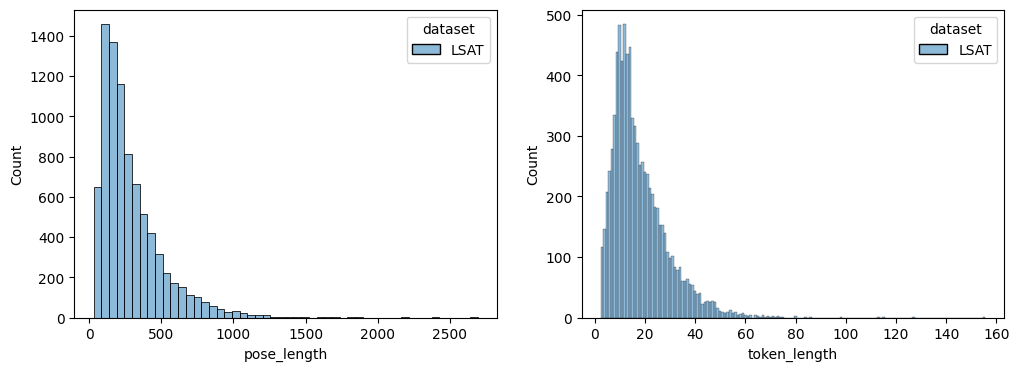

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=df, x="pose_length", hue="dataset", bins=50, ax=axs[0])
sns.histplot(
    data=df, x="token_length", hue="dataset", bins=50, ax=axs[1], discrete=True
)
plt.show()

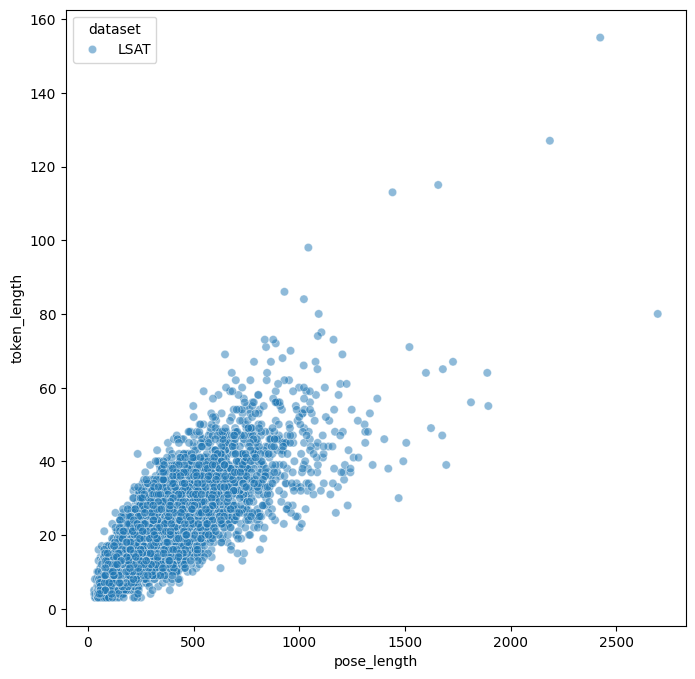

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=df, x="pose_length", y="token_length", hue="dataset", alpha=0.5, ax=ax
)
plt.show()

## Word frequency analysis

Percentage of different sentences over the whole dataset

In [17]:
print(f"Unique sentences per dataset: \n{df.groupby('dataset')['text'].nunique()}")
print(
    f"Unique sentences percentage per dataset: \n{100 * df.groupby('dataset')['text'].nunique() / df.groupby('dataset')['text'].count()}"
)

Unique sentences per dataset: 
dataset
LSAT    8016
Name: text, dtype: int64
Unique sentences percentage per dataset: 
dataset
LSAT    94.863905
Name: text, dtype: float64


In [19]:
full_texts = df.groupby("dataset").agg({"token_ids": "sum"})
full_texts["token_ids"] = full_texts["token_ids"].apply(
    lambda tokens: list(filter(lambda token: token != 2 and token != 3, tokens))
)
print(f"Vocab size per dataset: \n{full_texts['token_ids'].apply(set).apply(len)}")

Vocab size per dataset: 
dataset
LSAT    20472
Name: token_ids, dtype: int64


In [14]:
full_texts_dfs = {
    dataset: pd.DataFrame(
        {"token": full_texts.loc[dataset, "token_ids"]},
    )
    for dataset in DATASETS
}
token_freqs = {}
for dataset in DATASETS:
    frequency_counts = (
        full_texts_dfs[dataset].value_counts().value_counts().sort_index()
    )
    token_freqs[dataset] = 100 * frequency_counts / frequency_counts.sum()

token_freqs_df = pd.DataFrame(token_freqs)
token_freqs_df.head()

,LSAT
count,
1,58.616647
2,15.127980
3,7.258695
4,4.288785
5,2.676827


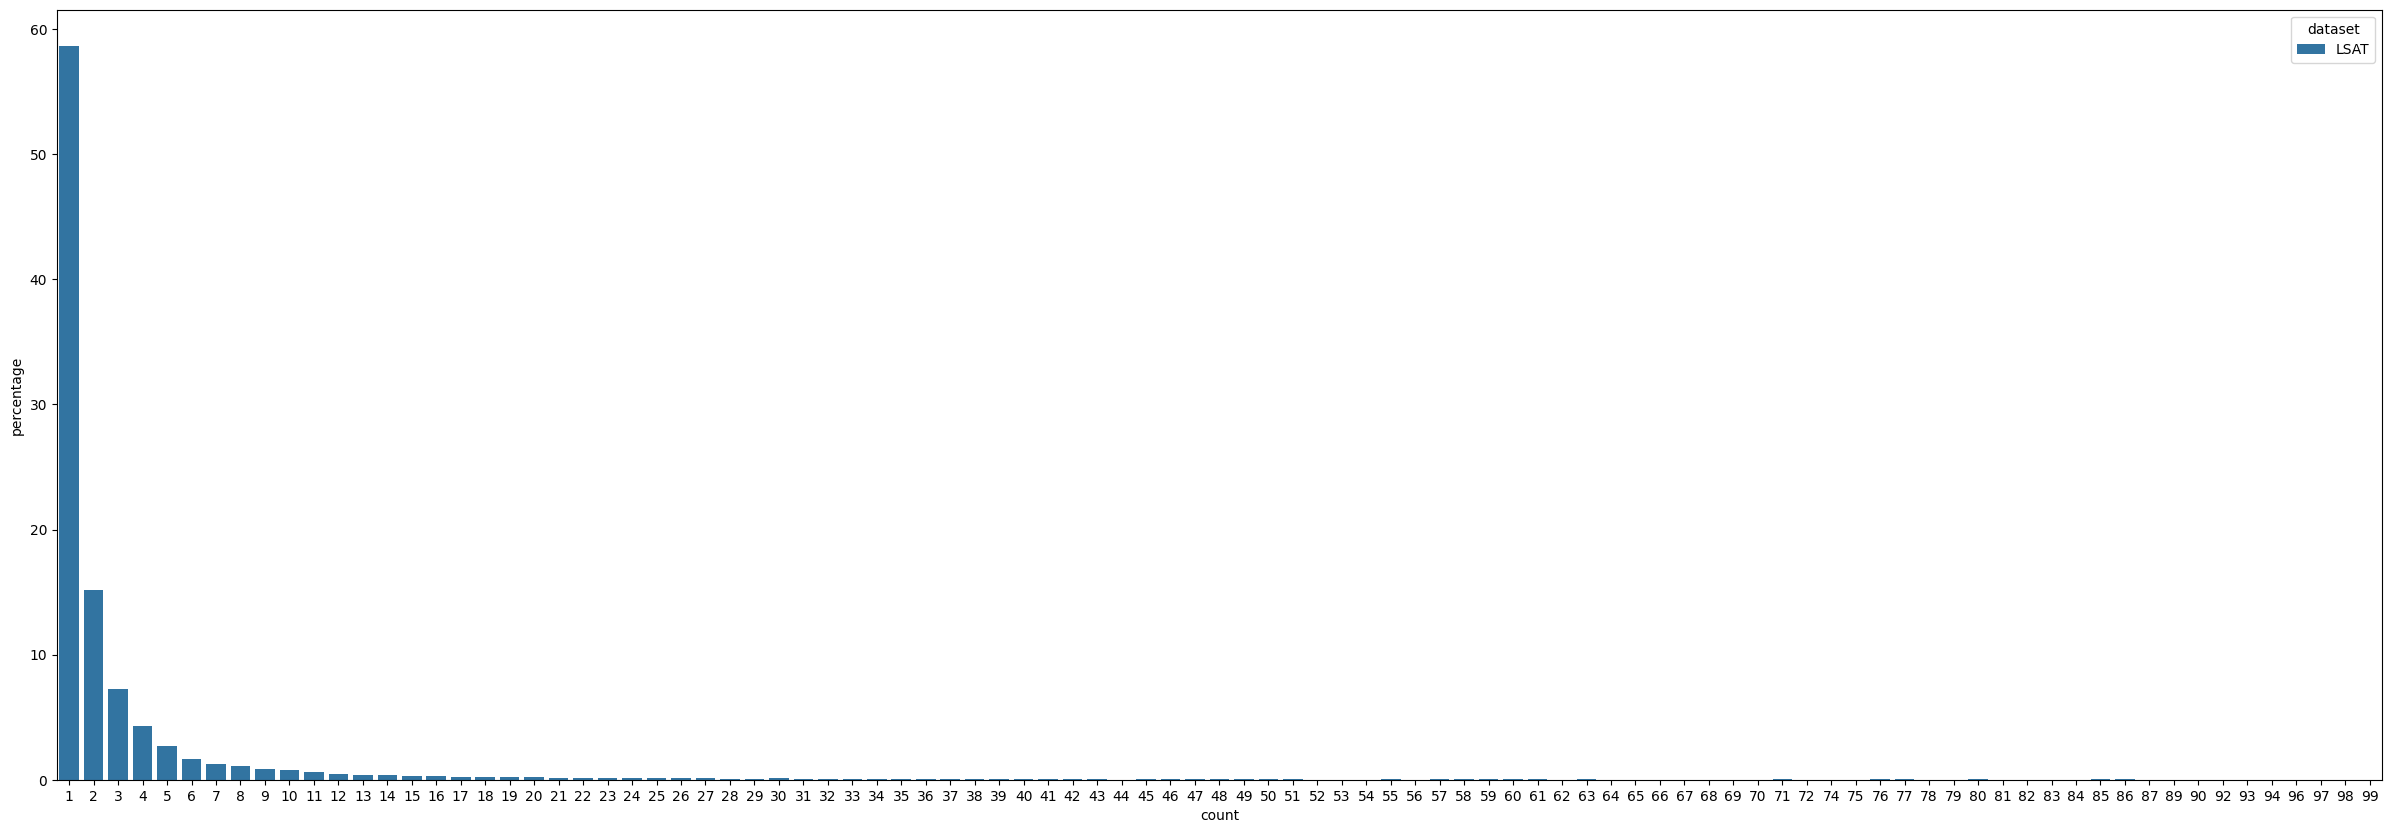

In [15]:
TO_PLOT = 95
token_freqs_top = (
    token_freqs_df[:TO_PLOT].reset_index().rename(columns={"index": "count"})
)
token_freqs_top_melted = token_freqs_top.melt(
    id_vars="count", var_name="dataset", value_name="percentage"
)

plt.figure(figsize=(30, 10))
sns.barplot(x="count", y="percentage", hue="dataset", data=token_freqs_top_melted)
plt.show()